# Clasificador de datos que permita reconocer la marcha - Hold Out


- Josefa Fernández

## 0. Initial Setup (carga de libreriías)

In [185]:
# Actualizar ciervo
! pip install ciervo --upgrade

   ---------------------------------------- 5.3/5.3 MB 4.5 MB/s eta 0:00:00
  Attempting uninstall: ciervo
    Found existing installation: ciervo 2024.7.15
    Uninstalling ciervo-2024.7.15:
      Successfully uninstalled ciervo-2024.7.15



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [186]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

fatal: destination path 'balu3' already exists and is not an empty directory.


Processing c:\users\josef\onedrive\escritorio\ciervo\experimentos clasificadores\con redes neuronales\balu3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=44144 sha256=ce6e8cf92cf3a27c9b43022295c89ee30bbd14cf27d87d759eeaf7fe5cdca2dd
  Stored in directory: C:\Users\josef\AppData\Local\Temp\pip-ephem-wheel-cache-oau4owq9\wheels\26\84\f7\85d5d3605d77e590f2a008b1d3cdee28dd43729ddd035e4819
Successfully built balu3
  Attempting uninstall: balu3
    Found existing installation: balu3 1.0
    Uninstalling balu3-1.0:
      Successfully uninstalled balu3-1.0



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [187]:
from balu3.fs.sel  import sfs, clean        
from balu3.ft.norm import minmax    

In [188]:
# ciervo
from ciervo.plots import emg_plot
from ciervo.io import example_marcha

# Manejar señales y otros usos
from scipy import signal
import scipy.signal
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import numpy as np
from scipy.fft import fft

import seaborn as sns
import pandas as pd
import cv2
from scipy.ndimage import binary_fill_holes


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, accuracy_score    

import torch.nn.functional as F

## 1. Data Loading

Tomo los archivos de ciervo/tests/data/marcha son 17 archivos

In [189]:
data_files  = example_marcha() # 17 dataframes con data
len(data_files)

17

Dataframe en pandas
 
Elapsed Time: Tiempo en segundos 

- **Isquio:** Señal EMG del músculo isquiotibial 
- **Cuadriceps:** Señal EMG del músculo cuádriceps 
- **GLMedio:** Señal EMG del músculo glúteo medio 
- **AductorLargo:** Señal EMG del músculo aductor largo 
- **Angle** 

## 2. Feature Extraction (función extracción caracteristicas del 100% de los datos)

### 2.1. Downsampling and feature extraction from EMG signals

#### 2.1.1. Identifica y visualiza cumbres en señal de angulo de la marcha

Se usa find_peaks para identificar cumbres en la señal de angulo de los datos de marcha. 

Retorna peaks[0], con indices de los picos encontrados en la señal de angulo. Como también se realiza una figura para visualizar las cumbres detectadas, representado con un punto rojo.

[ 808 1112 1399 1698 1918 2203 2484 2761 3029 3263 3511 3772 4049 4317
 4585 4863 5123 5399 5669 5954]


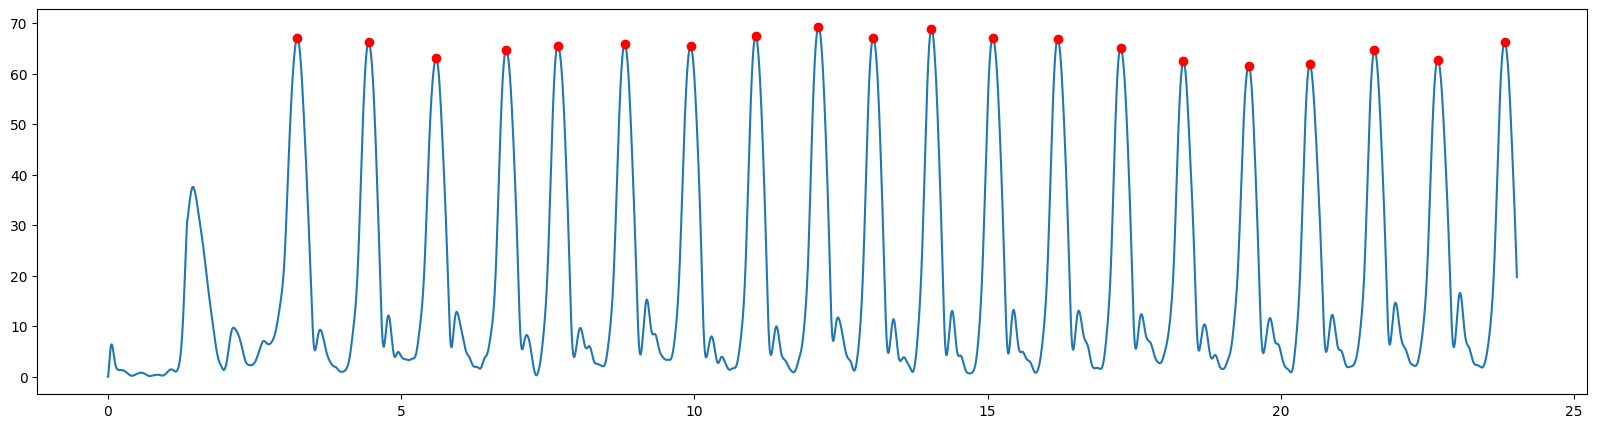

In [190]:
peaks = find_peaks(data_files[0]['Angle'], height=50, distance=125, width=20)
print(peaks[0])
#figura
fig = plt.figure(figsize=(20, 5))
plt.plot(data_files[0]['Elapsed Time'], data_files[0]['Angle'])
plt.plot(peaks[0]/250, data_files[0]['Angle'][peaks[0]], 'ro') 
plt.show()

#### 2.1.2. Visualizar segmentos de la señal de angulo correspondientes a los ciclos de marcha detectados entre las cumbres

Cada segmento se grafica sobre el mismo eje para comparar visualmente los diferentes ciclos de marcha. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


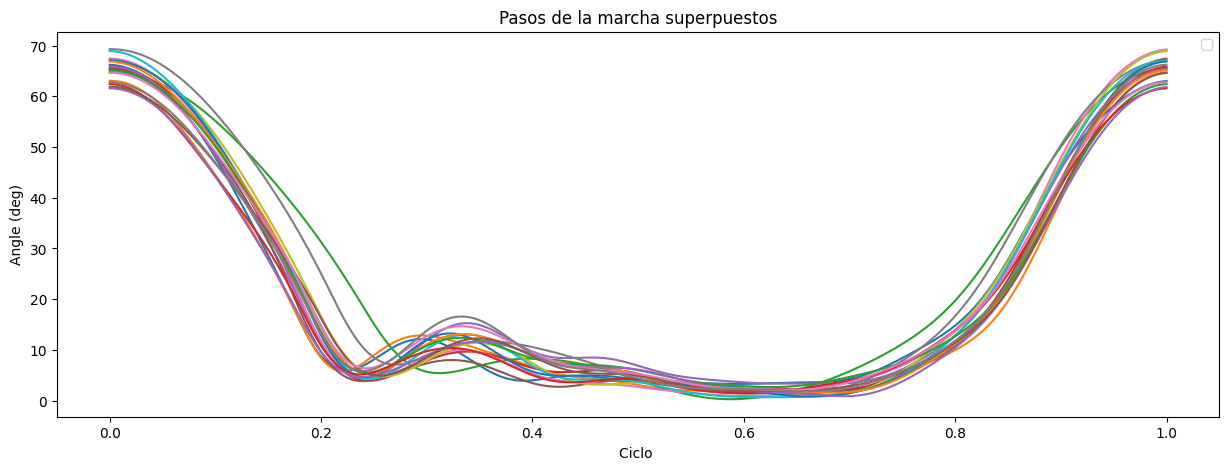

In [191]:
step = [] #almacena segmentos de la señal de angulo

# extrae segmentos de la señal basados en las cumbres
for i in range(1, len(peaks[0])-1):
    step.append(np.array(data_files[0]['Angle'][peaks[0][i]:peaks[0][i+1]]))   

# creacion figura para visualizar
fig = plt.figure(figsize=(15, 5))

#grafico cada segmento de la marcha
for i in range(len(step)):
    t = np.linspace(0, 1, len(step[i]))
    plt.plot(t, step[i])

plt.xlabel('Ciclo ')
plt.ylabel('Angle (deg)')
plt.legend()
plt.title('Pasos de la marcha superpuestos')
plt.show()

### 2.2. Preparando datos

In [192]:
# Definicion muscles
muscles = data_files[0].columns[1:-1]   #columnas del df de musculos en datos de EMG


# Inicializar listas
step = [] #pasos
emg = []  #ventanas de EMG normalizadas
file = [] #indice del archivo de origen de cada paso

# Itero sobre archivos de datos
for index, data in enumerate(data_files):

    # Deteccion de cumbres en la señal de angulo (altura min, distancia min entre cumbres, ancho min de la cumbre)
    peaks = find_peaks(data['Angle'], height=50, distance=125, width=20)

    # Extraccion y Normalizacion de ventanas de datos
    for i in range(1, len(peaks[0])-1):
        step.append(np.array(data['Angle'][peaks[0][i]:peaks[0][i+1]]))
        emg_window = data[muscles][peaks[0][i]:peaks[0][i+1]].reset_index(drop=True)
        emg_window = np.array(emg_window)

        # normalize
        emg_window = (emg_window - emg_window.mean())/emg_window.std() # asegura media 0 y std 1 de los datos
        emg.append(emg_window) # un paso normalizado de la marcha
        file.append(index) # archivo al que pertenece el paso

# Convertir de file a un array de numpy
file = np.array(file)

### 2.3 Visualizar datos EMG por 4 musculos diferentes

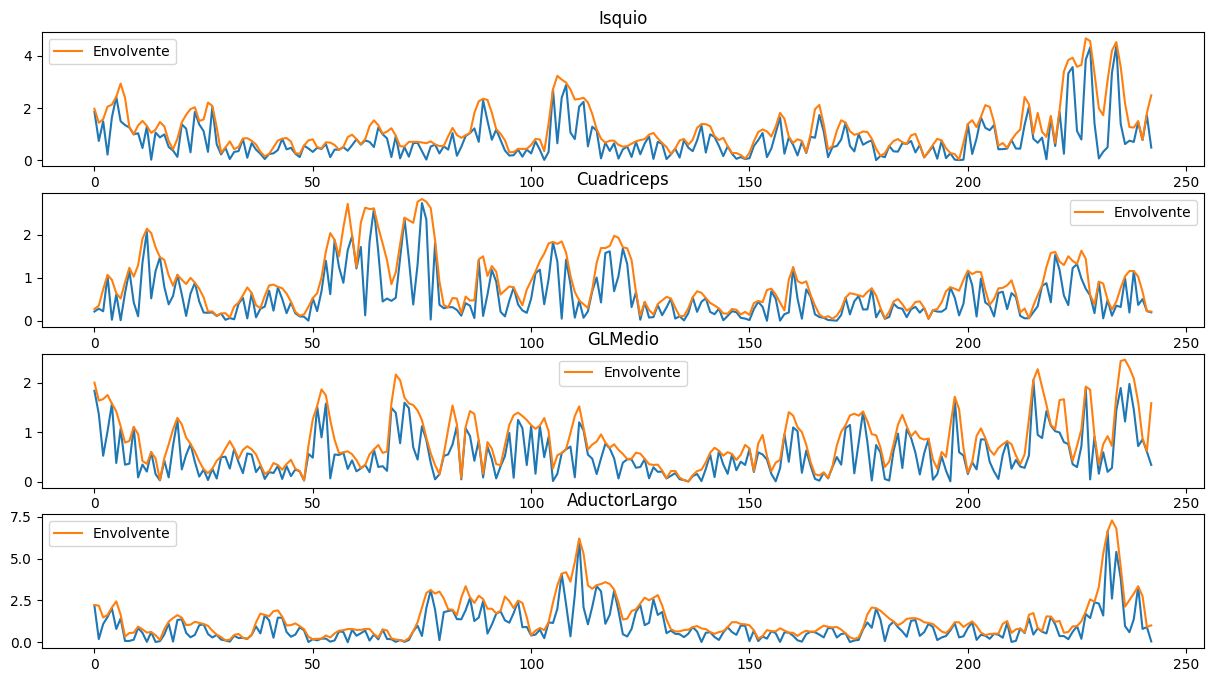

In [193]:
fig,ax = plt.subplots(4, 1, figsize=(15, 8))

# itero sobre ejes para graficar
for i in range(4):
    #grafico señal con rectificacion de onda completa
    ax[i].plot(np.abs(emg_window[:, i]))  # Señal con full wave rectification 
    
    # Calculo de la envolvente usando transformada de hilbert
    env = np.abs(signal.hilbert(emg_window[:, i]))
    ax[i].plot(env, label='Envolvente')
    ax[i].set_title(muscles[i])
    ax[i].legend()

plt.show()

### 2.4. Define feature extraction function


Caracteristicas Dominio del Tiempo
- **RMS (root mean square):** medida enegia señal - refleja act muscular
- **Varianza:** medidad variabilidad señal - indica cambios en act muscular
- **Kurtosis:** info sobre distribucion datos
- **Skewness:** mide asimetria distribucion señal
- **ZC (zero crossing):** numero de veces que señal cruza el eje cero - indicativo de la frecuencia de disparo de los musculos.

Caracterisicas Dominio de la Frecuencia
- **Espectro de potencia:** distribucion potencia de señal en funcion de frecuencia
- **Mediana de la frecuencia:** frecuencia bajo del cual se encuentra el 50% de la potencia del espectro de la señal
- **Frecuencia Media:** promedio ponderado de las frecuencias presentes en la señal
- **cumbre de Frecuencia:** frecuencia con la mayor potencia en el espectro

Caracteristicas de la Envolvente
- **promedios de la envolvente:** 
- **desviacion estandar de la envolvente:**
- **maximos de la envolvente:**
- **minimos de la envolvente:**

Extraer caracteristicas de datos de EMG

In [194]:
# Función para la transformada de Fourier
#cita de libreria balu3 de Domingo Mery balu3.fx.chr, adapte a este entorno
def fourier(signal, Nfourier=64, nfourier=4, norm=False):
    F = np.abs(fft(signal, n=Nfourier))
    f = F[:Nfourier//2]  # Solo la mitad positiva
    f = f[:nfourier]  # Redimensionar si es necesario
    if norm:
        f = f / np.linalg.norm(f)
    return f

In [195]:
#Funcion extraccion caracteristicas
def extract_feature(data, C=[0], divide=3):
    # data : (T, 4) 
    # T numero de muestras, 4 canales de EMG
    # C numero de indices de canales a usar
    # divide: divide la señal en partes iguales

    result = []
    for c in C:
        signal0 = data[:, c]

        # Full wave rectification
        rectified_signal = np.abs(signal0)

        #envolvente
        env = np.abs(signal.hilbert(data[:, c]))

        #RMS
        rms = np.sqrt(np.mean(rectified_signal**2))

        #Varianza
        var = np.var(rectified_signal)

        #kurtosis
        kurt = scipy.stats.kurtosis(rectified_signal)

        #skewness
        skew = scipy.stats.skew(rectified_signal)

        #zero crossing
        zc = ((rectified_signal[:-1] * rectified_signal[1:]) < 0).sum()

        #Frecuencias
        freqs, power_spectrum = scipy.signal.welch(rectified_signal, fs=250)
        median_freq = freqs[np.where(np.cumsum(power_spectrum) >= np.sum(power_spectrum) / 2)[0][0]]
        mean_freq = np.sum(freqs * power_spectrum) / np.sum(power_spectrum)
        peak_freq = freqs[np.argmax(power_spectrum)]

        # Transformada de Fourier
        #fft_vals = np.fft.fft(rectified_signal)
        #fft_freqs = np.fft.fftfreq(len(rectified_signal), d=1/250)  # Frecuencias correspondientes
        #fft_amplitudes = np.abs(fft_vals)
        #max_fft_amplitude = np.max(fft_amplitudes)
        #peak_fft_freq = fft_freqs[np.argmax(fft_amplitudes)]

        #SEGMENTOS
        for i in range(divide):
            start = int(i*len(data)/divide)
            end = int((i+1)*len(data)/divide)

            segment_env = env[start:end]
            mean_env = segment_env.mean()
            std_env = segment_env.std()
            max_env = segment_env.max()
            min_env = segment_env.min()
            result.extend([mean_env, std_env, max_env, min_env])
        
        # Fourier descriptors
        fourier_feats = fourier(rectified_signal)
        result.extend(fourier_feats)

    result.extend([rms, var, kurt, skew, zc, median_freq, mean_freq, peak_freq])
    #result.extend([rms, var, kurt, skew, zc, median_freq, mean_freq, peak_freq, max_fft_amplitude, peak_fft_freq])
    result = np.array(result)
    return result

In [196]:
# itera sobre datos (division en fases, extrae caract para cada fase, etiquetado)
# conversion a arrays
def label_data_and_features(data, C= [0, 1, 2, 3], divide=3):
    features = []
    labels = []
    for e in data:
        T, _ = e.shape
        for i in range(num_fases):
            start = int(i*T/num_fases)
            end = int((i+1)*T/num_fases)
            features.append(extract_feature(e[start:end, :], C=C, divide=divide))
            labels.append(i)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

## 3. Training and testing subsets (definir conjuntos de training y testing)

In [197]:
#Preparacion de datos para entrenamiento y prueba
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [ 1, 2, 3]  # Canales a utilizar -> Cuadriceps, GLMedio y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels = label_data_and_features(emg[:np.sum(file != 16)], C, divide)
test_data, test_labels = label_data_and_features(emg[np.sum(file != 16):], C, divide)


In [198]:
def clean_normalized_feature_selection(train_data, test_data):
  #Se entrena usando Training y Validation
  sclean       = clean(train_data)      # indices of selected features
  train_data = train_data[:,sclean]   # new training
  test_data  = test_data[:,sclean]    # new testing

  train_data, a, b = minmax(train_data)
  test_data        = test_data * a + b

  return train_data, test_data

In [199]:
train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
sfs_indices = sfs(train_data, train_labels, 45) # se pide que sean 50 caracterisitcas
train_data = train_data[:,sfs_indices] # Selecciona las columnas de Xtrain
test_data  =  test_data[:,sfs_indices] # Selecciona las columnas de Xtest
print(sfs_indices)

[40 20 32 48 49 24 29 12 10 45 44  4  2 13 41 26 35 19 53 36 33 38  3 42
 50 51 23 25 14 28 34 54 39  7 47  0 22 21 27 31  8 43 16 18 46]


## 4. Classification & Evaluation

 ### Simple NN
 

In [200]:
## 5. Classification

# Definir la estructura de la red neuronal
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hiperparametros
input_size = train_data.shape[1]
hidden_size = 100
output_size = num_fases
learning_rate = 0.001
num_epochs = 100

# Crear el modelo
model = SimpleNN(input_size, hidden_size, output_size)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Preparar los datos para PyTorch
train_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_tensor = torch.tensor(test_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [201]:
## Evaluation

# Entrenamiento de la red neuronal
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluación del modelo en el conjunto de prueba
with torch.no_grad():
    model.eval()
    test_outputs = model(test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(test_labels_tensor, predicted)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Matriz de confusión
    conf_matrix = confusion_matrix(test_labels_tensor, predicted)
    print(f'Confusion Matrix:\n{conf_matrix}')


Epoch [10/100], Loss: 0.5544
Epoch [20/100], Loss: 0.2514
Epoch [30/100], Loss: 0.1296
Epoch [40/100], Loss: 0.1761
Epoch [50/100], Loss: 0.7790
Epoch [60/100], Loss: 0.5871
Epoch [70/100], Loss: 0.1061
Epoch [80/100], Loss: 0.3424
Epoch [90/100], Loss: 1.1027
Epoch [100/100], Loss: 0.3265
Accuracy: 86.67%
Confusion Matrix:
[[13  1  1  0]
 [ 0 13  0  2]
 [ 0  2 12  1]
 [ 0  1  0 14]]


### CNN

In [202]:
# shape de train_data
print(f'Shape of train_data: {train_data.shape}')

#estructura CNN
class GaitCNN(nn.Module):
    def __init__(self, input_length):
        super(GaitCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # Calcular el tamaño después de la capa de pooling
        self._to_linear = None
        self.convs(torch.randn(1, 1, input_length))
        self.fc1 = nn.Linear(self._to_linear, 64)
        self.fc2 = nn.Linear(64, num_fases)

    def convs(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self._to_linear is None:
            self._to_linear = x.shape[1] * x.shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Supongamos que train_data tiene la forma (n_samples, sequence_length)
# Añadir una dimensión de canales
train_data_expanded = train_data[:, None, :]  # Añadir dimensión de canales
test_data_expanded = test_data[:, None, :]

# Convertir a tensores
train_data_tensor = torch.tensor(train_data_expanded, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_tensor = torch.tensor(test_data_expanded, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Obtener la longitud de la secuencia para inicializar el modelo
input_length = train_data_tensor.shape[2]

# Creación de conjuntos de datos y cargadores de datos
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Entrenamiento del modelo
cnn_model = GaitCNN(input_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 25

for epoch in range(num_epochs):
    cnn_model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

Shape of train_data: (1028, 45)
Epoch 1/25, Loss: 1.4110640287399292
Epoch 2/25, Loss: 1.3835196495056152
Epoch 3/25, Loss: 1.1823747158050537
Epoch 4/25, Loss: 0.9833149909973145
Epoch 5/25, Loss: 0.6981717348098755
Epoch 6/25, Loss: 1.2028003931045532
Epoch 7/25, Loss: 0.7144224047660828
Epoch 8/25, Loss: 0.691033661365509
Epoch 9/25, Loss: 0.3653234541416168
Epoch 10/25, Loss: 0.301142156124115
Epoch 11/25, Loss: 0.5826960206031799
Epoch 12/25, Loss: 0.3019537329673767
Epoch 13/25, Loss: 0.7830749154090881
Epoch 14/25, Loss: 0.2765130400657654
Epoch 15/25, Loss: 0.20186275243759155
Epoch 16/25, Loss: 2.0280418395996094
Epoch 17/25, Loss: 0.30060088634490967
Epoch 18/25, Loss: 0.6120232343673706
Epoch 19/25, Loss: 1.0621964931488037
Epoch 20/25, Loss: 0.4192372262477875
Epoch 21/25, Loss: 0.07319702953100204
Epoch 22/25, Loss: 0.35762885212898254
Epoch 23/25, Loss: 0.7030133605003357
Epoch 24/25, Loss: 0.547163188457489
Epoch 25/25, Loss: 0.32688233256340027


In [203]:
# Evaluación
cnn_model.eval()
test_outputs = []
test_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = cnn_model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_outputs.extend(outputs.numpy())
        test_predictions.extend(predicted.numpy())

cnn_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy of CNN: {cnn_accuracy}')

Accuracy of CNN: 0.8333333333333334


### RNN

In [212]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

# Verificar la forma de train_data
print(f'Shape of train_data: {train_data.shape}')

# Asegurarse de que train_data tiene tres dimensiones
if len(train_data.shape) == 2:
    train_data = train_data[:, :, np.newaxis]  # Añadir una dimensión extra al final
    test_data = test_data[:, :, np.newaxis]

class GaitRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GaitRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Configurar el estado oculto inicial y el estado de la celda
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Pasar los datos a través de la LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Tomar el último tiempo para la salida
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Supongamos que train_data tiene la forma (n_samples, sequence_length, n_features)
input_size = train_data.shape[2]  # Número de características (n_features)
hidden_size = 64
num_layers = 2
num_classes = num_fases

# Convertir a tensores
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Creación de conjuntos de datos y cargadores de datos
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Inicializar el modelo, la función de pérdida y el optimizador
rnn_model = GaitRNN(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
num_epochs = 25

# Entrenamiento del modelo
for epoch in range(num_epochs):
    rnn_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')


Shape of train_data: (1028, 45, 1)
Epoch 1/25, Loss: 1.407353162765503
Epoch 2/25, Loss: 1.393428921699524
Epoch 3/25, Loss: 1.2918908596038818
Epoch 4/25, Loss: 1.1867601871490479
Epoch 5/25, Loss: 0.9952541589736938
Epoch 6/25, Loss: 1.2816663980484009
Epoch 7/25, Loss: 1.2689646482467651
Epoch 8/25, Loss: 1.1491055488586426
Epoch 9/25, Loss: 1.3208316564559937
Epoch 10/25, Loss: 1.386523962020874
Epoch 11/25, Loss: 1.3789969682693481
Epoch 12/25, Loss: 1.4067654609680176
Epoch 13/25, Loss: 1.4015401601791382
Epoch 14/25, Loss: 1.3791556358337402
Epoch 15/25, Loss: 1.3987302780151367
Epoch 16/25, Loss: 1.372178077697754
Epoch 17/25, Loss: 1.3990216255187988
Epoch 18/25, Loss: 1.3739018440246582
Epoch 19/25, Loss: 1.3766990900039673
Epoch 20/25, Loss: 1.3923394680023193
Epoch 21/25, Loss: 1.3872570991516113
Epoch 22/25, Loss: 1.3868838548660278
Epoch 23/25, Loss: 1.3898754119873047
Epoch 24/25, Loss: 1.3834151029586792
Epoch 25/25, Loss: 1.386462688446045


In [213]:
# Evaluación del modelo
rnn_model.eval()
test_predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = rnn_model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.numpy())

rnn_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy of RNN: {rnn_accuracy}')

Accuracy of RNN: 0.25
